# Import libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Generating a Toy Dataset via Sampling from Different Exponential Smoothing Models

In [2]:
from metats.datasets import ETSDataset

N = 1024    # number of time series
LEN_TS = 32 # length of each time series

ets_generator = ETSDataset({'A,N,N': int(N/2),
                             'M,M,M': int(N/2)}, length=LEN_TS, freq=4)

data, labels = ets_generator.load(return_family=True)
colors = list(map(lambda x: (x=='A,N,N')*1, labels))

## Normalizing the time series

In [3]:
from sklearn.preprocessing import StandardScaler

scaled_data = StandardScaler().fit_transform(data.T)
data = scaled_data.T[:, :, None]

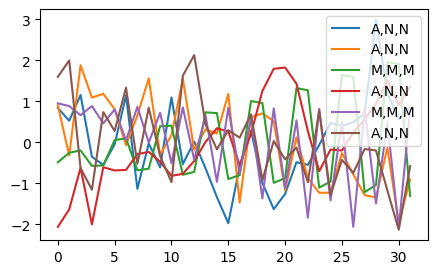

In [15]:
import matplotlib.pyplot as plt
import random
lt = random.sample(range(len(data)),6)
plt.figure(figsize=(5,3))
for i in lt: 
    _ = plt.plot(data[i, :, 0],label=labels[i])
plt.legend(loc='upper right');    

# Making and Training An Encoder-Decoder Temporal Convolutional Networks

In [4]:
from metats.features.unsupervised import DeepAutoEncoder
from metats.features.deep import AutoEncoder, Encoder_Decoder_TCN

# construct model
EDTCN = Encoder_Decoder_TCN(input_size=data.shape[2], input_length=data.shape[1],
                             hidden_layers=(4,1), kernel_size =4, dilation=2)
enc = EDTCN.encoder
dec = EDTCN.decoder

ae = AutoEncoder(encoder=enc, decoder=dec)

ae_feature = DeepAutoEncoder(auto_encoder=ae, epochs=100, verbose=False)

In [5]:
ae_feature.fit(data)

## Generating Encoder-Decoder TCN meta features:

In [6]:
deep_featurestcn = ae_feature.transform(data)
deep_featurestcn.shape

(1024, 8)

# Making and Training An Encoder-Decoder LSTM

In [9]:
from metats.features.unsupervised import DeepAutoEncoder
from metats.features.deep import AutoEncoder, LSTMDecoder, LSTMEncoder

H = 5   # hidden size
l = 3   # latent size
NL= 2   # number of layers

enc = LSTMEncoder(input_size=data.shape[2], latent_size=l,
                 hidden_size=H, num_layers=NL, directions=1)
dec = LSTMDecoder(output_length=LEN_TS, output_size=1,
                 latent_size=l, hidden_size=H, num_layers=NL, directions=1)

ae = AutoEncoder(encoder=enc, decoder=dec)

ae_feature = DeepAutoEncoder(auto_encoder=ae, epochs=70, verbose=False)

In [10]:
ae_feature.fit(data)

## Generating Encoder-Decoder LSTM meta features:

In [12]:
deep_featuresls = ae_feature.transform(data)
deep_featuresls.shape

(1024, 3)

# Generating Statistical Features using TsFresh

In [74]:
from metats.features.statistical import TsFresh

stat_features = TsFresh().transform(data)
stat_features.shape

Feature Extraction: 100%|██████████| 10/10 [02:45<00:00, 16.58s/it]


(1024, 430)

# Dimensionality Reduction for Visualization 

In [21]:
from umap import UMAP
stat_reduced = UMAP().fit_transform(stat_features)
deep_reducedls = UMAP().fit_transform(deep_featuresls)
deep_reducedtcn = UMAP().fit_transform(deep_featurestcn.reshape(N,-1))

## Visualizing the Meta-Features

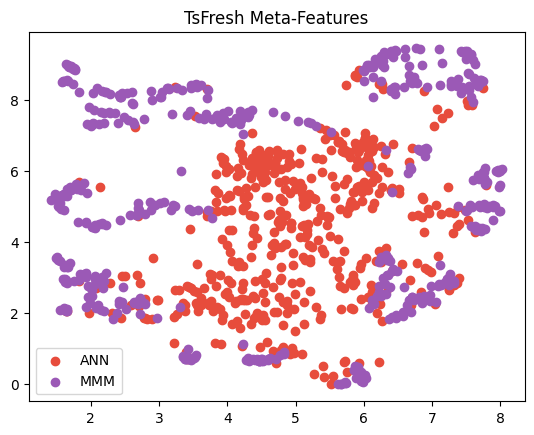

In [76]:
plt.scatter(stat_reduced[:int(N/2), 0], stat_reduced[:int(N/2), 1], c='#e74c3c', label='ANN')
plt.scatter(stat_reduced[int(N/2):, 0], stat_reduced[int(N/2):, 1], c='#9b59b6', label='MMM')
plt.legend()
plt.title('TsFresh Meta-Features')
_ = plt.show()

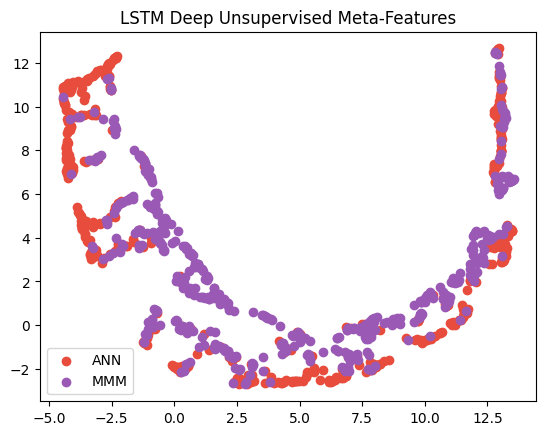

In [22]:
plt.scatter(deep_reducedls[:int(N/2), 0], deep_reducedls[:int(N/2), 1], c='#e74c3c', label='ANN')
plt.scatter(deep_reducedls[int(N/2):, 0], deep_reducedls[int(N/2):, 1], c='#9b59b6', label='MMM')
plt.legend()
plt.title('LSTM Deep Unsupervised Meta-Features')
_ = plt.show()

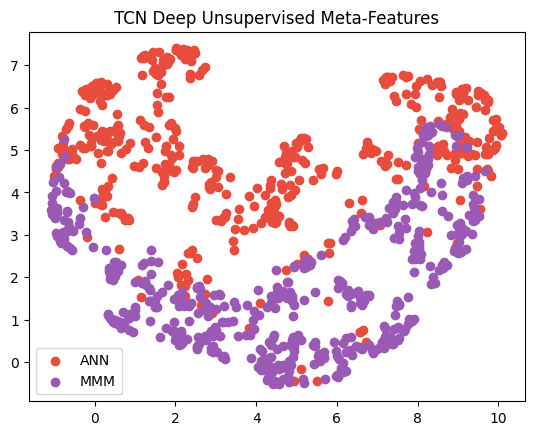

In [20]:
plt.scatter(deep_reducedtcn[:int(N/2), 0], deep_reducedtcn[:int(N/2), 1], c='#e74c3c', label='ANN')
plt.scatter(deep_reducedtcn[int(N/2):, 0], deep_reducedtcn[int(N/2):, 1], c='#9b59b6', label='MMM')
plt.legend()
plt.title('TCN Deep Unsupervised Meta-Features')
_ = plt.show()